# Transitorios

Dada una línea sin pérdidas de longitud $l=100$ m suministra energía a una carga de $Z_L=100$ $\Omega$. El generador es de continua, suministra un voltaje de 10 V y tiene una impedancia interna de 50 $\Omega$. En $t=0$ se conecta el generador a la fuente. Estudiar el fenómeno transitorio y determinar voltaje e intensidad a mitad de la línea. Considerar que $Z_0=75$ $\Omega$ and $v=0.25 c$.

Repetir el ejercicio para diferentes cargas:
- $Z_L$= $\infty$
- $Z_L$= 0 $\Omega$
- $Z_L$= 25 $\Omega$

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import numpy as np
import matplotlib.pyplot as plt

Definimos unas variables con los datos del problema:

In [3]:
# Trabajamos en el SI. Datos del problema
v0g=10.   # Voltaje del generador
z0=75.    # Impedancia caracteristica
zg=50.   # Impedancia del generador
zl=100    # Impedancia de carga
c=299792458.0
vo=0.25*c   # Velocidad de onda
lol=100.    # Longitud de la linea

La solución del problema según la teoría de circuitos de parámetros localizados es:

In [12]:
i_esta=v0g/(zg+zl)         # Intensidad segun TC
v_esta=zl*i_esta      # Voltaje segun TC
print('Intensidad segun TC (mA): {0:6.3F}'.format(i_esta*1E3))
print('Voltaje segun TC (V): {0:5.3F}'.format(v_esta))

Intensidad segun TC (mA): 66.667
Voltaje segun TC (V): 6.667


El tiempo que tarda la onda en recorrer la línea viene dado por:

In [5]:
dt=lol/vo           # Intervalo de tiempo (en ns)
print('Incremento temporal (microsegundos): {0:6.3F}'.format(dt*1.e6))

Incremento temporal (microsegundos):  1.334


En $t=0^+$ la onda se empieza a propagar por el comienzo de la línea (al lado del generador):

In [10]:
iin=v0g/(zg+z0)         # Intensidad inicial
vin=z0*iin              # Voltaje inicial
print('Intensidad a la entrada (mA): {0:6.3F}'.format(iin*1E3))
print('Voltaje a la entrada (V): {0:5.3F}'.format(vin))

Intensidad a la entrada (mA): 80.000
Voltaje a la entrada (V): 6.000


El comportamiento de la onda en la línea de transmisión viene determinado por los coeficientes de reflexión en la carga y en el generador:

In [11]:
gammaL=(zl-z0)/(zl+z0)  # Coef. reflex. carga
gammaG=(zg-z0)/(zg+z0)  # Coef. reflex. generador
print('Coeficiente de reflexion en la carga={0:5.4F}'.format(gammaL))
print('Coeficiente de reflexion en el generador={0:5.4F}'.format(gammaG))

Coeficiente de reflexion en la carga=0.1429
Coeficiente de reflexion en el generador=-0.2000


Estos valores se usarán más abajo. Corresponde a la transcripción en código de la sección 1.5.1.

Se comienza definiendo los vectores donde se guardan los voltajes e intensidades reflejados de forma sucesiva en los límites físicos de la línea (generador, carga).
Hay que dimensionar un número más que el valor de ndt, porque el primer valor corresponde al 0. 
En el intervalo 0 la onda se propaga desde el generador a la carga (onda incidente) y no tiene parte reflejada.
Comenzamos el ciclo en el intervalo 1, cuando la onda se ha reflejado en la carga y vuelve desde la carga al generador.
Si el índice es par, el voltaje reflejado corresponde al valor anterior multiplicado por $\Gamma_G$.
Si el índice es impar hay que multiplicar por $\Gamma_L$. 

Para la intensidad hay que considerar el signo negativo en la ecuación (1.9).

In [6]:
def transih(t):
### Variables globales: dt, vin, z0, gammaG, gammaL ###
    ndt=int(np.floor(t/dt) )      # Numero de intervalos con reflexion en t
    ins=np.ones(ndt+1,dtype=float)    # Intensidades reflejadas
    inst=np.ones(ndt+1,dtype=float)   # Intensidades totales
    vos=np.ones(ndt+1,dtype=float)    # Voltajes reflejados
    vost=np.ones(ndt+1,dtype=float)   # Voltajes totales
    vos[0]=vin
    ins[0]=vin/z0
    vost[0]=vos[0]
    inst[0]=ins[0]
    for i in range(1,ndt+1):          # Si ndt==0 no hace nada
        if i%2 != 0:                  # Impar
            vr=vos[i-1]*gammaL
            ir=-vr/z0   
        else:
            vr=vos[i-1]*gammaG
            ir=vr/z0    
        vos[i]=vr
        vost[i]=vost[i-1]+vr
        ins[i]=ir
        inst[i]=inst[i-1]+ir
    return (vos,ins,vost,inst)


In [7]:
def transizt(z,t):
### Variables globales: dt, vin, z0, gammaG, gammaL, vo ###
    vose , inse , voste, inste = transih(t)
    ndt=int(np.floor(t/dt))     # Numero de intervalos cumplidos
    rdt=t-ndt*dt                # Resto del tiempo
    if ndt == 0:
        if z<rdt*vo:  # La onda llega a z
            return voste[0],inste[0]
        else:
            return 0,0
    elif ndt%2 == 0:    # no par de reflexiones
        if z<rdt*vo:  # La onda reflejada llega a z
            return voste[ndt],inste[ndt]
        else:         
            return voste[ndt-1],inste[ndt-1]
    else:             # no impar de reflexiones
        if lol-z<rdt*vo:      
            return voste[ndt],inste[ndt]
        else:
            return voste[ndt-1],inste[ndt-1]

In [18]:
vosp,insp,vostp,instp = transih(7e-6)
print('Voltajes reflejados (V)=\n',vosp)
print('Intensidades reflejadas (mA)=\n',insp*1E3)

Voltajes reflejados (V)=
 [ 6.00000000e+00  8.57142857e-01 -1.71428571e-01 -2.44897959e-02
  4.89795918e-03  6.99708455e-04]
Intensidades reflejadas (mA)=
 [ 8.00000000e+01 -1.14285714e+01 -2.28571429e+00  3.26530612e-01
  6.53061224e-02 -9.32944606e-03]


In [19]:
vz2,iz2=transizt(lol/2,5E-6)
print('Voltaje (V) e intensidad (mA) a mitad de la linea en t=5 micro s\n',vz2,'\n',iz2*1E3)

Voltaje (V) e intensidad (mA) a mitad de la linea en t=5 micro s
 6.661224489795917 
 66.6122448979592


In [20]:
ndtrepre=6
tiempos=np.linspace(0,ndtrepre,100)*dt
voltajes=np.zeros(100)
vfis=np.ones(100)*v_esta
ifis=np.ones(100)*i_esta
intensidades=np.zeros(100)
for i, tiempo in enumerate(tiempos):
    voltajes[i] , intensidades[i] = transizt(lol/2,tiempo)

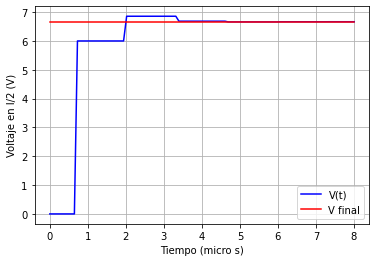

In [21]:
plt.plot(tiempos*1e6,voltajes,c='b',label='V(t)')
plt.plot(tiempos*1e6,vfis,c='r',label='V final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Voltaje en l/2 (V)')
plt.legend(loc=4)
plt.show()

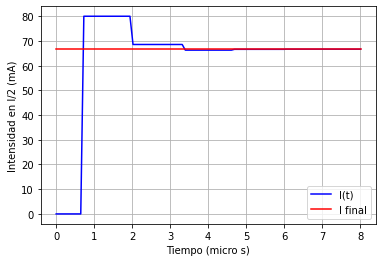

In [23]:
plt.plot(tiempos*1e6,intensidades*1E3,c='b',label='I(t)')
plt.plot(tiempos*1e6,ifis*1E3,c='r',label='I final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Intensidad en l/2 (mA)')
plt.legend(loc=4)
plt.show()

### Caso con $Z_L=\infty$

Es el mismo caso anterior pero con la línea en abierto.

In [2]:
# Trabajamos en el SI. Datos del problema
v0g=10.   # Voltaje del generador
z0=75.    # Impedancia caracteristica
zg=50.   # Impedancia del generador
zl=100E6    # Impedancia de carga
c=299792458.0
vo=0.25*c   # Velocidad de onda
lol=100.    # Longitud de la linea

In [3]:
iin=v0g/(zg+z0)         # Intensidad inicial
vin=z0*iin              # Voltaje inicial
dt=lol/vo           # Intervalo de tiempo (en ns)
ifi=v0g/(zg+zl)         # Intensidad segun TC
vfi=zl*ifi      # Voltaje segun TC
print('Intensidad a la entrada (A): {0:9.3E}'.format(iin))
print('Voltaje a la entrada (V): {0:8.3E}'.format(vin))
print('Intensidad segun TC (A): {0:9.3E}'.format(ifi))
print('Voltaje segun TC (V): {0:8.3E}'.format(vfi))
print('Incremento temporal (microsegundos): {0:6.3F}'.format(dt*1.e6))

Intensidad a la entrada (A): 8.000E-02
Voltaje a la entrada (V): 6.000E+00
Intensidad segun TC (A): 1.000E-07
Voltaje segun TC (V): 1.000E+01
Incremento temporal (microsegundos):  1.334


In [4]:
gammaL=(zl-z0)/(zl+z0)  # Coef. reflex. carga
gammaG=(zg-z0)/(zg+z0)  # Coef. reflex. generador
print('Coeficiente de reflexion en la carga={0:5.4F}'.format(gammaL))
print('Coeficiente de reflexion en el generador={0:5.4F}'.format(gammaG))

Coeficiente de reflexion en la carga=1.0000
Coeficiente de reflexion en el generador=-0.2000


In [8]:
vosp,insp,vostp,instp = transih(7e-6)
print(vosp)
print(insp)

[ 6.          5.999991   -1.1999982  -1.1999964   0.23999928  0.23999892]
[ 0.08       -0.07999988 -0.01599998  0.01599995  0.00319999 -0.00319999]


In [9]:
transizt(lol/2,5E-6)

(9.5999964, 9.599996400599942e-08)

In [10]:
ndtrepre=6
tiempos=np.linspace(0,ndtrepre,100)*dt
voltajes=np.zeros(100)
vfis=np.ones(100)*vfi
ifis=np.ones(100)*ifi
intensidades=np.zeros(100)
for i, tiempo in enumerate(tiempos):
    voltajes[i] , intensidades[i] = transizt(lol/2,tiempo)

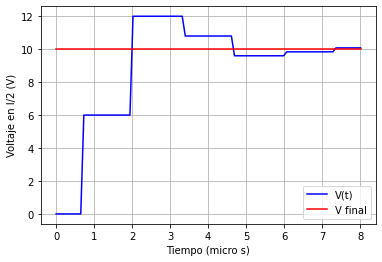

In [11]:
plt.plot(tiempos*1e6,voltajes,c='b',label='V(t)')
plt.plot(tiempos*1e6,vfis,c='r',label='V final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Voltaje en l/2 (V)')
plt.legend(loc=4)
plt.show()

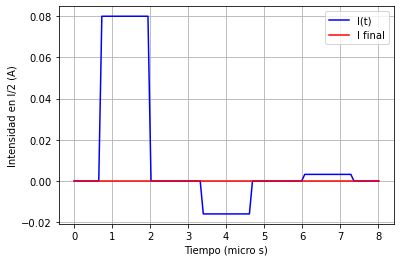

In [12]:
plt.plot(tiempos*1e6,intensidades,c='b',label='I(t)')
plt.plot(tiempos*1e6,ifis,c='r',label='I final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Intensidad en l/2 (A)')
plt.legend(loc=1)
plt.show()

### Caso con $Z_L=0$

Mismo caso anterior, pero con la línea en corto.

In [13]:
# Trabajamos en el SI. Datos del problema
v0g=10.   # Voltaje del generador
z0=75.    # Impedancia caracteristica
zg=50.   # Impedancia del generador
zl=0    # Impedancia de carga
c=299792458.0
vo=0.25*c   # Velocidad de onda
lol=100.    # Longitud de la linea

In [14]:
iin=v0g/(zg+z0)         # Intensidad inicial
vin=z0*iin              # Voltaje inicial
dt=lol/vo           # Intervalo de tiempo (en ns)
ifi=v0g/(zg+zl)         # Intensidad segun TC
vfi=zl*ifi      # Voltaje segun TC
print('Intensidad a la entrada (A): {0:9.3E}'.format(iin))
print('Voltaje a la entrada (V): {0:8.3E}'.format(vin))
print('Intensidad segun TC (A): {0:9.3E}'.format(ifi))
print('Voltaje segun TC (V): {0:8.3E}'.format(vfi))
print('Incremento temporal (microsegundos): {0:6.3F}'.format(dt*1.e6))

Intensidad a la entrada (A): 8.000E-02
Voltaje a la entrada (V): 6.000E+00
Intensidad segun TC (A): 2.000E-01
Voltaje segun TC (V): 0.000E+00
Incremento temporal (microsegundos):  1.334


In [15]:
gammaL=(zl-z0)/(zl+z0)  # Coef. reflex. carga
gammaG=(zg-z0)/(zg+z0)  # Coef. reflex. generador
print('Coeficiente de reflexion en la carga={0:5.4F}'.format(gammaL))
print('Coeficiente de reflexion en el generador={0:5.4F}'.format(gammaG))

Coeficiente de reflexion en la carga=-1.0000
Coeficiente de reflexion en el generador=-0.2000


In [16]:
vosp,insp,vostp,instp = transih(5e-6)
print(vosp)
print(insp)

[ 6.  -6.   1.2 -1.2]
[0.08  0.08  0.016 0.016]


Voltaje e intensidad en mitad de la línea en $t=5$ $\mu$s:

In [17]:
transizt(lol/2,5E-6)

(0.0, 0.19200000000000003)

In [18]:
ndtrepre=6
tiempos=np.linspace(0,ndtrepre,100)*dt
voltajes=np.zeros(100)
vfis=np.ones(100)*vfi
ifis=np.ones(100)*ifi
intensidades=np.zeros(100)
for i, tiempo in enumerate(tiempos):
    voltajes[i] , intensidades[i] = transizt(lol/2,tiempo)

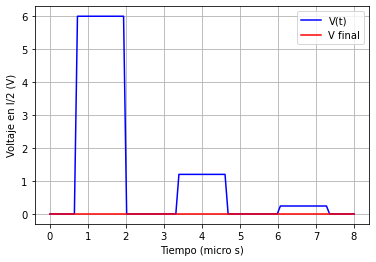

In [19]:
plt.plot(tiempos*1e6,voltajes,c='b',label='V(t)')
plt.plot(tiempos*1e6,vfis,c='r',label='V final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Voltaje en l/2 (V)')
plt.legend(loc=1)
plt.show()

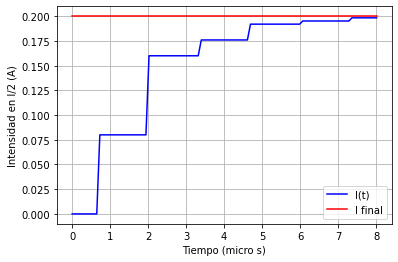

In [20]:
plt.plot(tiempos*1e6,intensidades,c='b',label='I(t)')
plt.plot(tiempos*1e6,ifis,c='r',label='I final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Intensidad en l/2 (A)')
plt.legend(loc=4)
plt.show()

### Caso con $Z_L=25$ $\Omega$


In [21]:
# Trabajamos en el SI. Datos del problema
v0g=10.   # Voltaje del generador
z0=75.    # Impedancia caracteristica
zg=50.   # Impedancia del generador
zl=25.   # Impedancia de carga
c=299792458.0
vo=0.25*c   # Velocidad de onda
lol=100.    # Longitud de la linea

In [22]:
iin=v0g/(zg+z0)         # Intensidad inicial
vin=z0*iin              # Voltaje inicial
dt=lol/vo           # Intervalo de tiempo (en ns)
ifi=v0g/(zg+zl)         # Intensidad segun TC
vfi=zl*ifi      # Voltaje segun TC
print('Intensidad a la entrada (A): {0:9.3E}'.format(iin))
print('Voltaje a la entrada (V): {0:8.3E}'.format(vin))
print('Intensidad segun TC (A): {0:9.3E}'.format(ifi))
print('Voltaje segun TC (V): {0:8.3E}'.format(vfi))
print('Incremento temporal (microsegundos): {0:6.3F}'.format(dt*1.e6))

Intensidad a la entrada (A): 8.000E-02
Voltaje a la entrada (V): 6.000E+00
Intensidad segun TC (A): 1.333E-01
Voltaje segun TC (V): 3.333E+00
Incremento temporal (microsegundos):  1.334


In [23]:
gammaL=(zl-z0)/(zl+z0)  # Coef. reflex. carga
gammaG=(zg-z0)/(zg+z0)  # Coef. reflex. generador
print('Coeficiente de reflexion en la carga={0:5.4F}'.format(gammaL))
print('Coeficiente de reflexion en el generador={0:5.4F}'.format(gammaG))

Coeficiente de reflexion en la carga=-0.5000
Coeficiente de reflexion en el generador=-0.2000


In [24]:
vosp,insp,vostp,instp = transih(5e-6)
print(vosp)
print(insp)

[ 6.  -3.   0.6 -0.3]
[0.08  0.04  0.008 0.004]


In [25]:
transizt(lol/2,5E-6)

(3.3, 0.132)

In [26]:
ndtrepre=6
tiempos=np.linspace(0,ndtrepre,100)*dt
voltajes=np.zeros(100)
vfis=np.ones(100)*vfi
ifis=np.ones(100)*ifi
intensidades=np.zeros(100)
for i, tiempo in enumerate(tiempos):
    voltajes[i] , intensidades[i] = transizt(lol/2,tiempo)

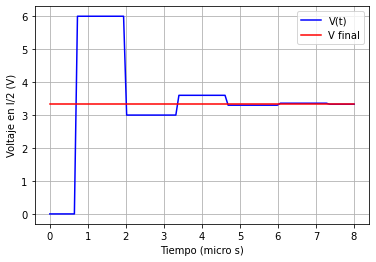

In [27]:
plt.plot(tiempos*1e6,voltajes,c='b',label='V(t)')
plt.plot(tiempos*1e6,vfis,c='r',label='V final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Voltaje en l/2 (V)')
plt.legend(loc=1)
plt.show()

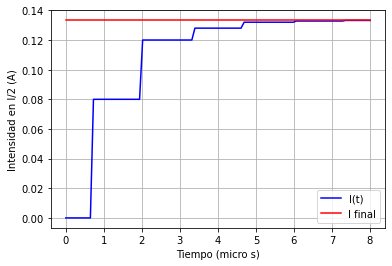

In [28]:
plt.plot(tiempos*1e6,intensidades,c='b',label='I(t)')
plt.plot(tiempos*1e6,ifis,c='r',label='I final')
plt.grid()
plt.xlabel('Tiempo (micro s)')
plt.ylabel('Intensidad en l/2 (A)')
plt.legend(loc=4)
plt.show()

## Pérdidas pequeñas

Esta parte es para dibujar pulsos atenuados en una linea

In [34]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def vp(z,t,v,alpha,v0p):
    zt=t-z/v
    return v0p*np.exp(-alpha*z)*np.exp(-(zt**2))

In [37]:
lli=100
v=1
alpha=0.001
v0p=10.
zlinea=np.linspace(0,lli,300)
t1=lli/v
onda1=vp(zlinea,t1/5,v,alpha,v0p)
onda2=vp(zlinea,2*t1/5,v,alpha,v0p)
onda3=vp(zlinea,3*t1/5,v,alpha,v0p)

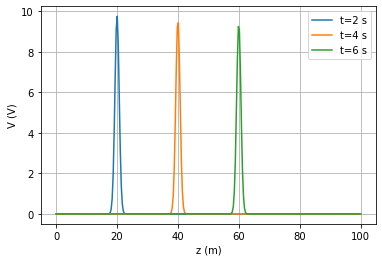

In [38]:
plt.plot(zlinea,onda1,label='t=2 s')
plt.plot(zlinea,onda2,label='t=4 s')
plt.plot(zlinea,onda3,label='t=6 s')
plt.xlabel('z (m)')
plt.ylabel('V (V)')
plt.grid()
plt.legend(loc=1)
plt.show()